# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [172]:
import lib.loadfunctions as lf 
import lib.analysisfunctions as af
import lib.plotfunctions as pf
import lib.savefunctions as svf
import lib.sanityfunctions as sanf
import lib.fieldtransformfunctions as ftf

import os
import math
import numpy as np

In [391]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(lf)
importlib.reload(af)
importlib.reload(pf)
importlib.reload(svf)
importlib.reload(sanf)
importlib.reload(ftf)

<module 'lib.fieldtransformfunctions' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/fieldtransformfunctions.py'>

### Load data

In [420]:
#variables related to loading
path = "M06_th45/"
path_fields = "M06_th45/"
path_particles = "M06_th45/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
numframe = 2000


In [421]:
#load fields
dfields = lf.field_loader(path=path_fields,num=numframe)

#load flow data
dflow = lf.flow_loader(path=path,num=numframe)

/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/loadfunctions.py:189: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[kc] = d[kc][slc]


In [50]:
import time
start = time.time()
dparticles = lf.readSliceOfParticles(path_particles, numframe, dfields['ex_xx'][0], dfields['ex_xx'][-1], dfields['ex_yy'][0], dfields['ex_yy'][1], dfields['ex_zz'][0], dfields['ex_zz'][1])
end = time.time()
print("Time consumed in loading: ",end - start)


Time consumed in loading:  71.7200219631195


In [28]:
dparticles

{'p1': array([ 1.0938492,  1.8259416,  2.6700335, ..., -3.9219215, -3.5298755,
        -3.3894234], dtype=float32),
 'p2': array([-0.02623025,  0.24160533, -0.21408969, ...,  1.2028141 ,
         0.12411342,  0.1014578 ], dtype=float32),
 'p3': array([ 0.5420574 ,  0.3836102 ,  0.43945238, ..., -0.50875485,
         0.25672367,  0.10022093], dtype=float32),
 'x1': array([ 0.42525226,  0.3513953 ,  0.8887675 , ..., 47.85496   ,
        47.867203  , 47.871426  ], dtype=float32),
 'x2': array([0.2541247 , 0.18340854, 0.33848837, ..., 0.14807953, 0.14090009,
        0.24028376], dtype=float32),
 'x3': array([0.34922934, 0.19364756, 0.31406802, ..., 0.34723735, 0.37020174,
        0.36550656], dtype=float32)}

In [29]:
import sys
sizetotal = sys.getsizeof(dparticles)
sizetotal /= 1073741824 #convert to mb
    
print('size of data: ' + str(sizetotal) + ' gb')

size of data: 3.427267074584961e-07 gb


### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

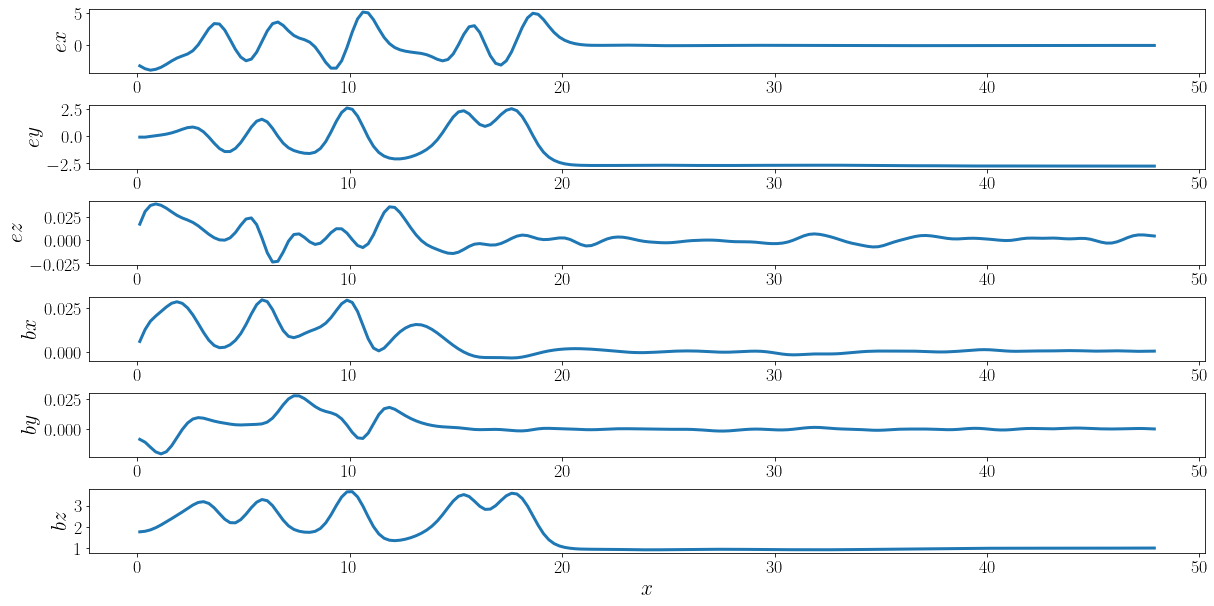

In [30]:
pf.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

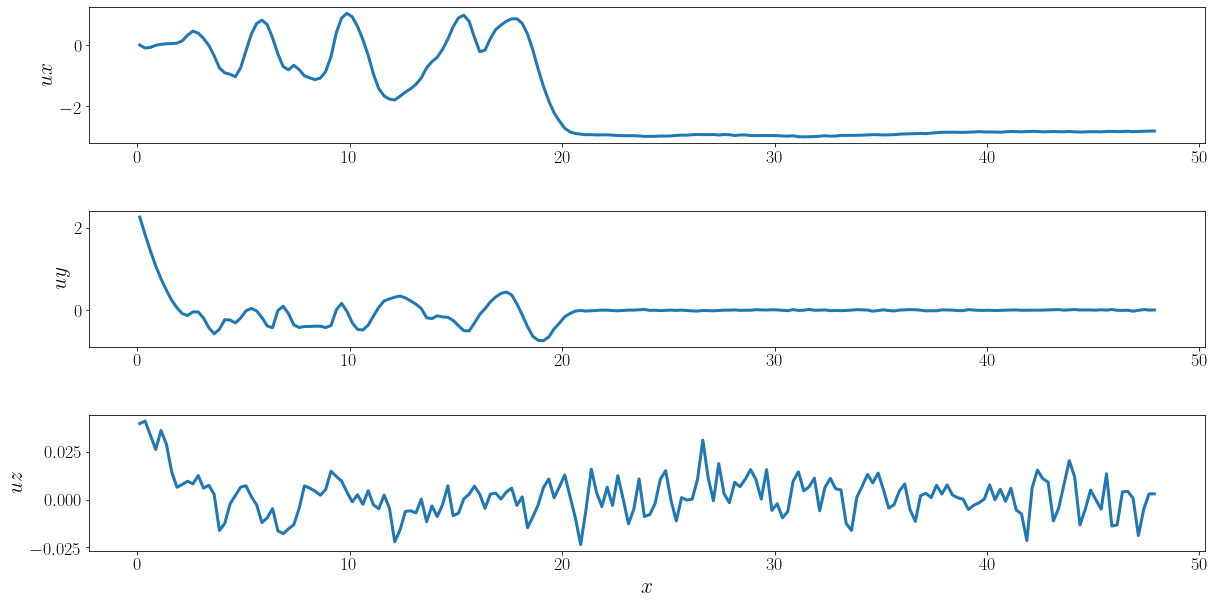

In [31]:
pf.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

In [32]:
#load fields
dfields = lf.field_loader(path=path_fields,num=numframe)

#load flow data
dflow = lf.flow_loader(path=path,num=numframe)

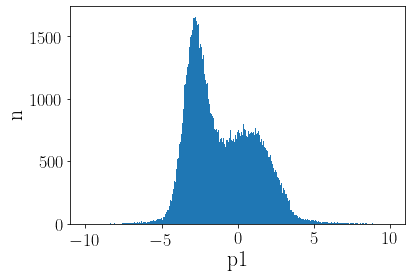

<Figure size 432x288 with 0 Axes>

In [33]:
pf.plot_1d_dist(dparticles3veltest, 'p1', 10., dfields['ex_xx'][0], dfields['ex_xx'][-1],dfields['ex_yy'][0], dfields['ex_yy'][-1])

### Compute Shock Vel and Lorentz transform fields

In [34]:
#pick some point in the middle of the simulation and plot it as a function of time
all_dfields = lf.all_dfield_loader(path=path_fields, verbose=False)


/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/loadfunctions.py:288: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[kc] = d[kc][slc]


In [35]:
vshock, xshockvals = af.shock_from_ex_cross(all_dfields)

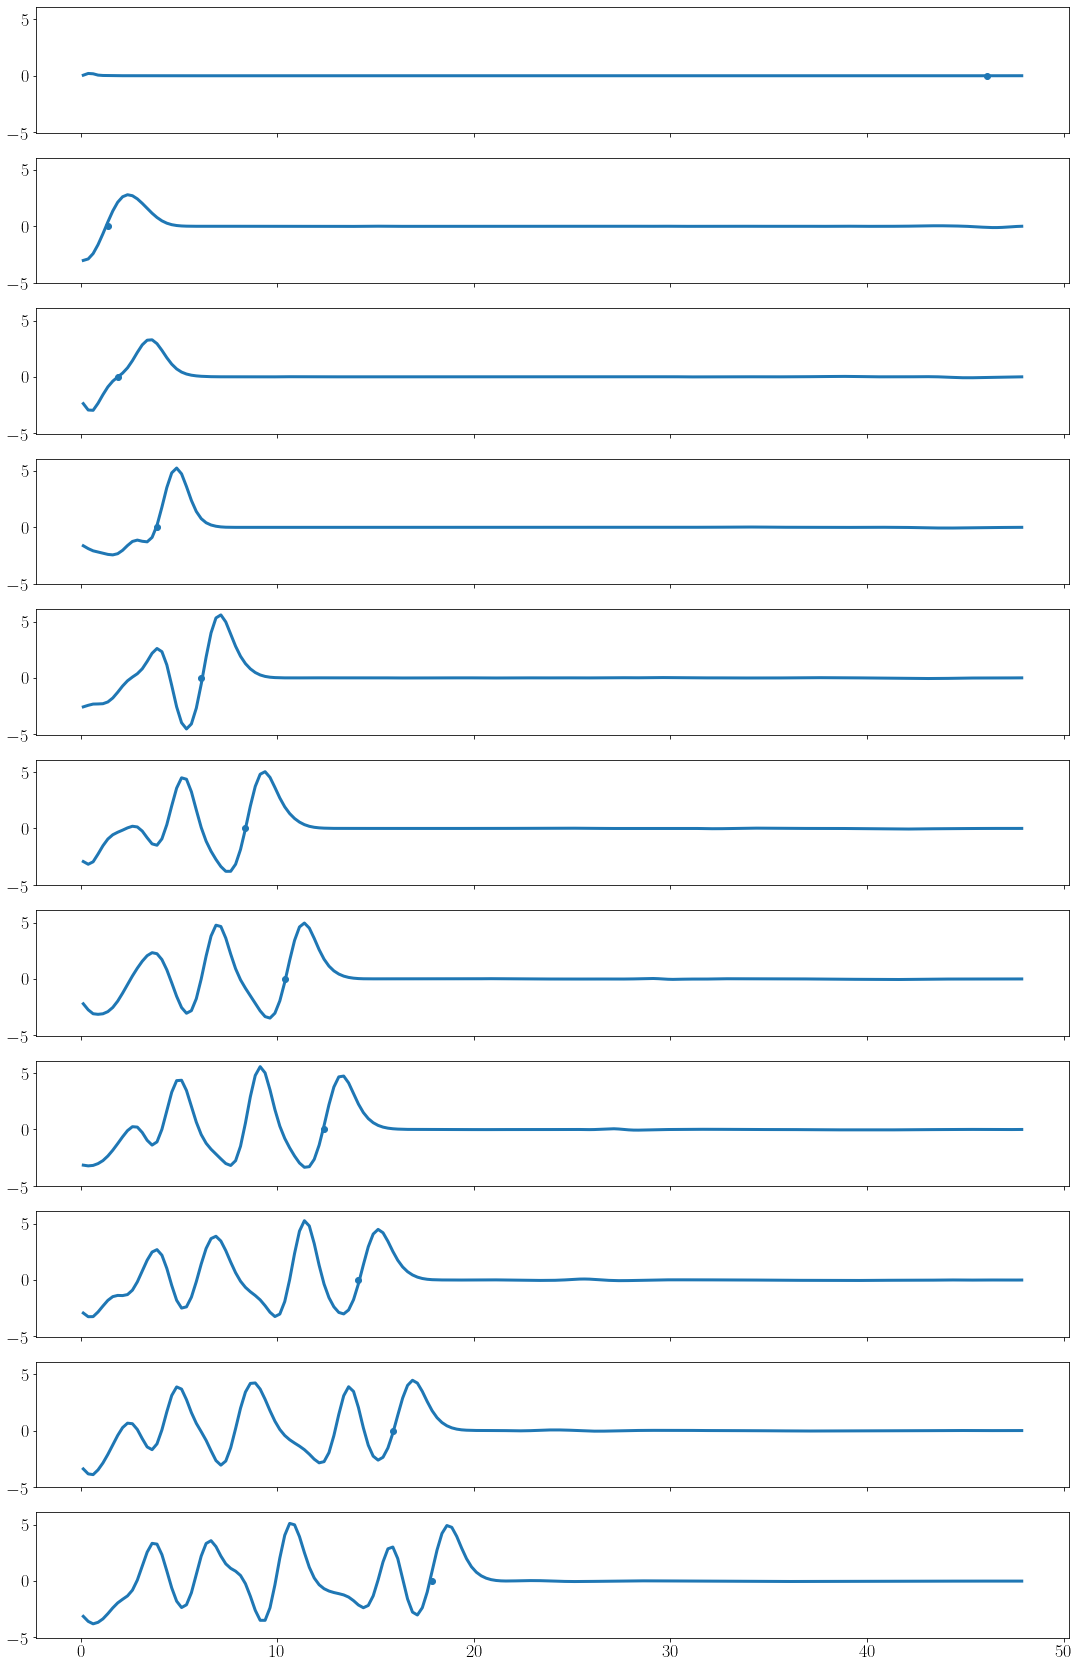

In [36]:
pf.stack_line_plot(all_dfields,'ex',xshockvals = xshockvals)

In [37]:
#Lorentz transform fields
dfields = ftf.lorentz_transform_vx(dfields,vshock)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ftf.lorentz_transform_vx(all_dfields['dfields'][k],vshock))
all_dfields['dfields'] = _fields

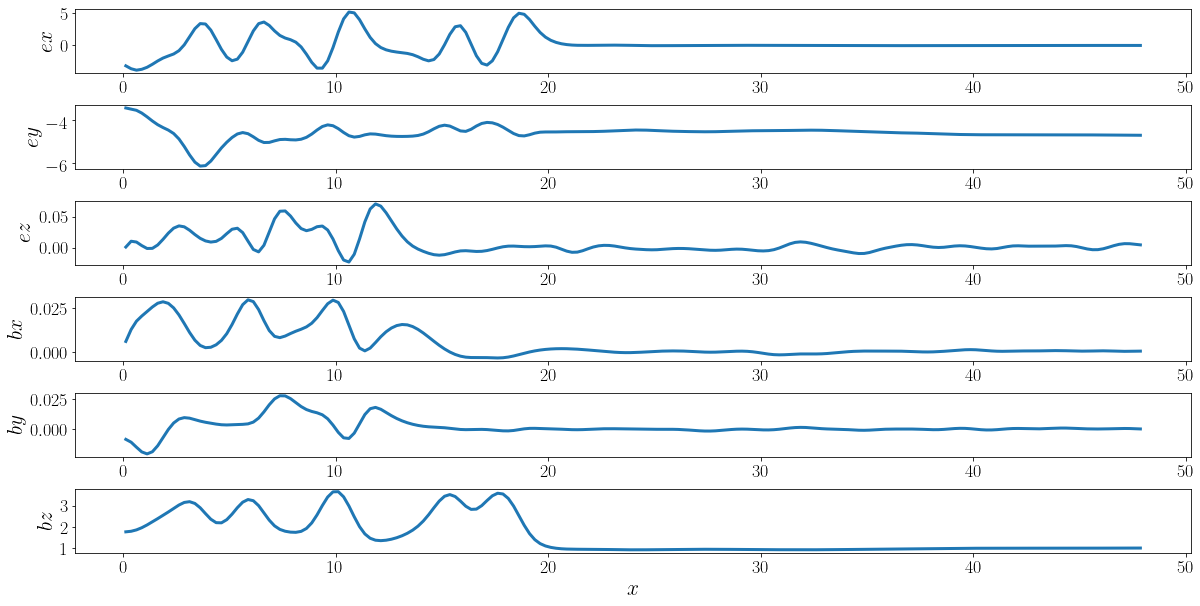

In [38]:
pf.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

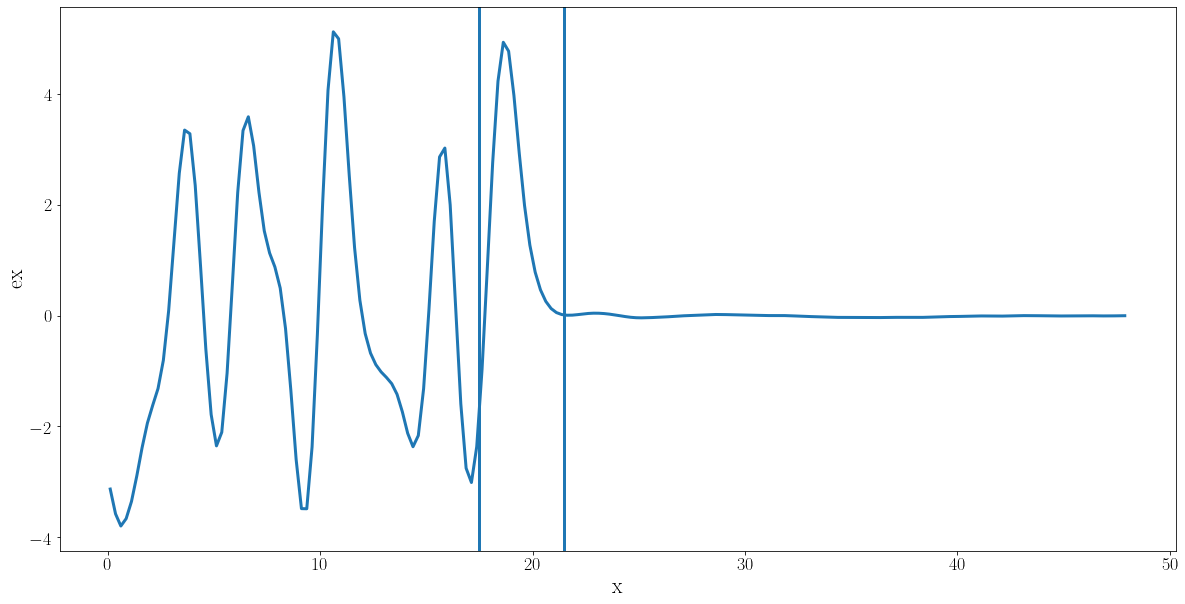

In [94]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 17.5#lower bound for metadata = 1 (di)
endval = 21.5 #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
pf.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [40]:
metadata = svf.build_metadata(dfields, startval, endval)

In [41]:
metadata

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Test super plot

In [45]:
x1 = 28.
x2 = 29.
y1 = 0.
y2 = 1.
z1 = 0.
z2 = 1.
vmax = 15.
dv = .25

vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEx = af.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles3veltest, dfields, vshock, 'ex', 'x')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEy = af.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles3veltest, dfields, vshock, 'ey', 'y')
vx, vy, vz, totalPtcl, totalFieldpts, Hist, CEz = af.compute_hist_and_cor(vmax, dv, x1, x2, y1, y2, z1, z2, dparticles3veltest, dfields, vshock, 'ez', 'z')

In [46]:
#Project onto correct axes
H_xy = af.threeHistToTwoHist(Hist,'xy')
H_xz = af.threeHistToTwoHist(Hist,'xz')
H_yz = af.threeHistToTwoHist(Hist,'yz')
CEx_xy = af.threeCorToTwoCor(CEx,'xy')
CEx_xz = af.threeCorToTwoCor(CEx,'xz')
CEx_yz = af.threeCorToTwoCor(CEx,'yz')
CEy_xy = af.threeCorToTwoCor(CEy,'xy')
CEy_xz = af.threeCorToTwoCor(CEy,'xz')
CEy_yz = af.threeCorToTwoCor(CEy,'yz')
CEz_xy = af.threeCorToTwoCor(CEz,'xy')
CEz_xz = af.threeCorToTwoCor(CEz,'xz')
CEz_yz = af.threeCorToTwoCor(CEz,'yz')

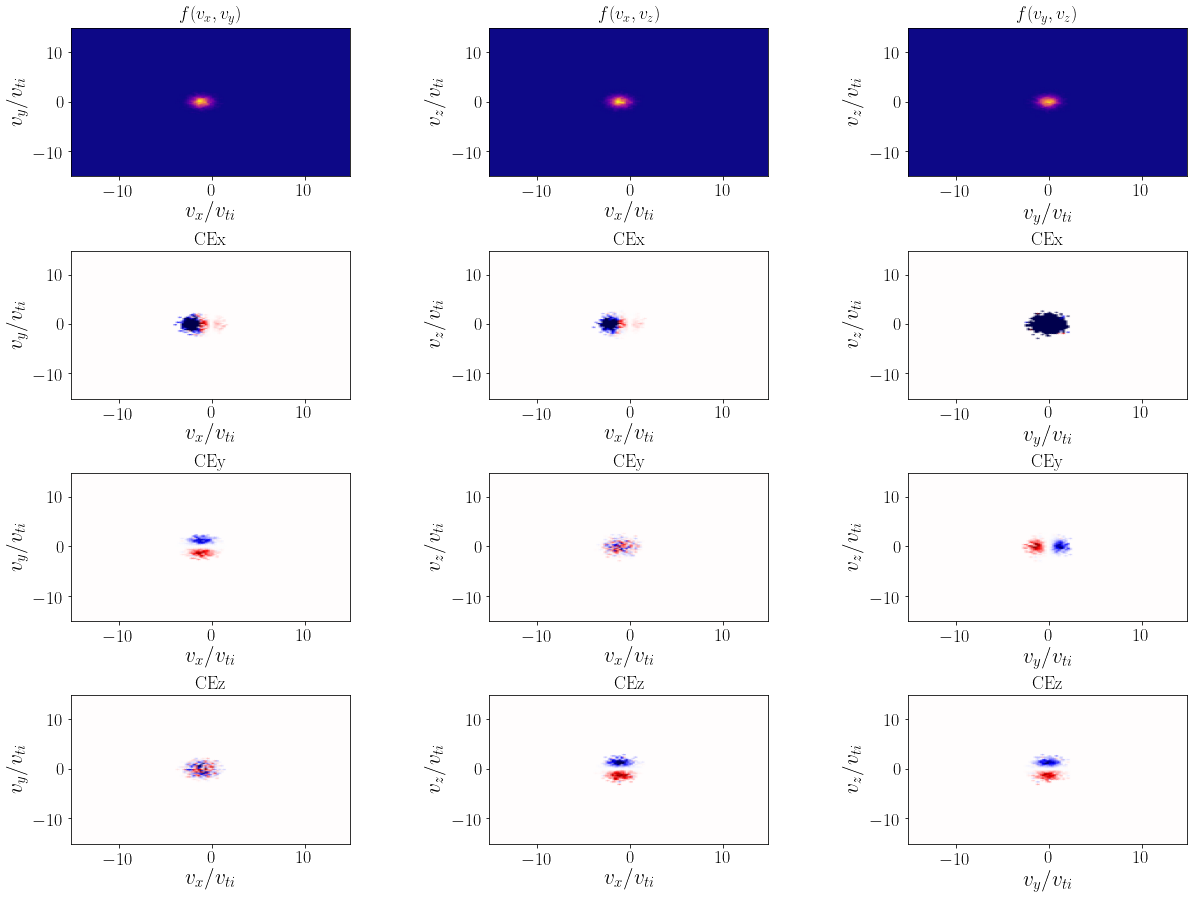

In [47]:
pf.plot_cor_and_dist_supergrid(vx, vy, vz, vmax,
                                H_xy, H_xz, H_yz,
                                CEx_xy,CEx_xz, CEx_yz,
                                CEy_xy,CEy_xz, CEy_yz,
                                CEz_xy,CEz_xz, CEz_yz)

### Perform FPC analysis

In [67]:
#Define parameters related to analysis
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0] #assumes rectangular grid thats uniform for all fields

In [111]:
#Compute correlation and distribution
#Note: CEx,CEy, CEz, vx, vy, vz are returned in their '3d' (i.e. 3d array) form.
#must project onto 2d plane to plot
CEx, CEy, CEz, x, Hist, vx, vy, vz = af.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock)

0.125 of 47.875
0.375 of 47.875
0.625 of 47.875
0.875 of 47.875
1.125 of 47.875
1.375 of 47.875
1.625 of 47.875
1.875 of 47.875
2.125 of 47.875
2.375 of 47.875
2.625 of 47.875
2.875 of 47.875
3.125 of 47.875
3.375 of 47.875
3.625 of 47.875
3.875 of 47.875
4.125 of 47.875
4.375 of 47.875
4.625 of 47.875
4.875 of 47.875
5.125 of 47.875
5.375 of 47.875
5.625 of 47.875
5.875 of 47.875
6.125 of 47.875
6.375 of 47.875
6.625 of 47.875
6.875 of 47.875
7.125 of 47.875
7.375 of 47.875
7.625 of 47.875
7.875 of 47.875
8.125 of 47.875
8.375 of 47.875
8.625 of 47.875
8.875 of 47.875
9.125 of 47.875
9.375 of 47.875
9.625 of 47.875
9.875 of 47.875
10.125 of 47.875
10.375 of 47.875
10.625 of 47.875
10.875 of 47.875
11.125 of 47.875
11.375 of 47.875
11.625 of 47.875
11.875 of 47.875
12.125 of 47.875
12.375 of 47.875
12.625 of 47.875
12.875 of 47.875
13.125 of 47.875
13.375 of 47.875
13.625 of 47.875
13.875 of 47.875
14.125 of 47.875
14.375 of 47.875
14.625 of 47.875
14.875 of 47.875
15.125 of 47.875
15.

### Make superplot gif

In [112]:
pf.make_superplot_gif(vx, vy, vz, vmax, Hist, CEx, CEy, CEz, x, 'superplotGraphs', 'superplottest.gif')

Making plot 0 of 191
Making plot 1 of 191
Making plot 2 of 191
Making plot 3 of 191
Making plot 4 of 191
Making plot 5 of 191
Making plot 6 of 191
Making plot 7 of 191
Making plot 8 of 191
Making plot 9 of 191
Making plot 10 of 191
Making plot 11 of 191
Making plot 12 of 191
Making plot 13 of 191
Making plot 14 of 191
Making plot 15 of 191
Making plot 16 of 191
Making plot 17 of 191
Making plot 18 of 191
Making plot 19 of 191
Making plot 20 of 191
Making plot 21 of 191
Making plot 22 of 191
Making plot 23 of 191
Making plot 24 of 191
Making plot 25 of 191
Making plot 26 of 191
Making plot 27 of 191
Making plot 28 of 191
Making plot 29 of 191
Making plot 30 of 191
Making plot 31 of 191
Making plot 32 of 191
Making plot 33 of 191
Making plot 34 of 191
Making plot 35 of 191
Making plot 36 of 191
Making plot 37 of 191
Making plot 38 of 191
Making plot 39 of 191
Making plot 40 of 191
Making plot 41 of 191
Making plot 42 of 191
Making plot 43 of 191
Making plot 44 of 191
Making plot 45 of 19

In [113]:
pf.make_gif_from_folder('superplotGraphs','superplottest.gif')

['000000.png', '000001.png', '000002.png', '000003.png', '000004.png', '000005.png', '000006.png', '000007.png', '000008.png', '000009.png', '000010.png', '000011.png', '000012.png', '000013.png', '000014.png', '000015.png', '000016.png', '000017.png', '000018.png', '000019.png', '000020.png', '000021.png', '000022.png', '000023.png', '000024.png', '000025.png', '000026.png', '000027.png', '000028.png', '000029.png', '000030.png', '000031.png', '000032.png', '000033.png', '000034.png', '000035.png', '000036.png', '000037.png', '000038.png', '000039.png', '000040.png', '000041.png', '000042.png', '000043.png', '000044.png', '000045.png', '000046.png', '000047.png', '000048.png', '000049.png', '000050.png', '000051.png', '000052.png', '000053.png', '000054.png', '000055.png', '000056.png', '000057.png', '000058.png', '000059.png', '000060.png', '000061.png', '000062.png', '000063.png', '000064.png', '000065.png', '000066.png', '000067.png', '000068.png', '000069.png', '000070.png', '0000

### Convert to previous '2d FPC' formatting

In [162]:
#for now, we just do CEx_xy CEy_xy
#Here we convert to the previous 2d format
#TODO: this takes a minute, probably only want to project once 
CEx_out = []
CEy_out = []
for i in range(0,len(CEx)):
    CEx_xy = af.threeCorToTwoCor(CEx[i],'xy')
    CEy_xy = af.threeCorToTwoCor(CEy[i],'xy')
    CEx_out.append(CEx_xy)
    CEy_out.append(CEy_xy)
    
vx_xy, vy_xy = af.threeVelToTwoVel(vx,vy,vz,'xy')
vx_out = vx_xy
vy_out = vy_xy
x_out = x

### Compute energization from correlations

In [163]:
#TODO: project onto 2d plane and handle different projections net energization
enerCEx_out = af.compute_energization_over_x(CEx_out,dv)
enerCEy_out = af.compute_energization_over_x(CEy_out,dv)

### Calculate relevant simulation parameters and save as netcdf4

In [174]:
inputdict = svf.parse_input_file(path)

In [175]:
params = svf.build_params(inputdict,numframe)

In [176]:
inputdict

{'': [''],
 'node_conf_node_number(1:3)': [14.0, 4.0, 4.0],
 'time_dt': [0.01],
 'time_niter': [1000.0],
 'time_t0': [0.0],
 'time_stiter': [0.0],
 'time_c': [125.0],
 'grid_space_ncells(1:3)': [192.0, 48.0, 48.0],
 'grid_space_boxsize(1:3)': [48.0, 12.0, 12.0],
 'grid_space_bdtype': ['reflect', 'open', 'per', 'per', 'per', 'per'],
 'grid_space_Te': [1.0],
 'grid_space_gamma': [1.66667],
 'global_output_dodump': ['.true.'],
 'global_output_ndump': [100.0],
 'global_output_B0': ['3.05191d-7'],
 'global_output_n0': ['1.d6'],
 'global_output_units': ['NORM'],
 'global_output_do_restart': ['.false.'],
 'global_output_save_restart': ['.true.'],
 'global_output_restart_step': [1000.0],
 'global_output_restart_time': [85000.0],
 'global_output_restart_time_step': [100.0],
 'ext_emf_Bx': [0.0],
 'ext_emf_By': [0.0],
 'ext_emf_Bz': [1.0],
 'ext_emf_Ex': [0.0],
 'ext_emf_Ey': [0.0],
 'ext_emf_Ez': [0.0],
 'ext_emf_n_constants': [0.0],
 'ext_emf_Jext(1:3)': [0.0, 0.0, 0.0],
 'ext_emf_NoiseLevel(1

In [177]:
params

{'MachAlfven': -3.0,
 'MachAlfvenNote': 'TODO: compute mach alfven for this run',
 'thetaBn': 90.0,
 'thetaBndesc': 'units of degrees',
 'betaelec': 1.0,
 'betaion': 0.5000000000190247,
 'simtime': 10.0,
 'simtimedesc': 'units of inverse Omega_{c,i,0}',
 'qi': 1.0,
 'qidesc': 'charge to mass ratio',
 'di': 0.0,
 'didesc': 'TODO: compute ion inertial length',
 'vti': 0.7071067812}

In [180]:
flnm = 'dHybridRSDAtest1newformatwithE.nc'
try:
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, metadata_out = [], params = params, filename = flnm)
except:
    os.system('rm '+flnm)
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, enerCEx_out, enerCEy_out, metadata_out = [], params = params, filename = flnm)

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [ ]:
CEx_in, CEy_in, vx_in, vy_in, x_in, enerCEx_in, enerCEy_in, metadata_in, params_in = svf.load_netcdf4(flnm)

### Make gif

In [ ]:
pf.make_velsig_gif(vx_in, vy_in, vmax, CEx_in, 'ex', x_out, 'CExframe1000', 'CExframe1000.gif')

<img src="CExframe1000.gif" width="750" align="center">

In [ ]:
pf.make_velsig_gif(vx_in, vy_in, vmax, CEy_in, 'ey', x_out, 'CEyframe1000', 'CEyframe1000.gif')

<img src="CEyframe1000.gif" width="750" align="center">

### Perform sanity checks
#### E cross B gif

In [ ]:
pf.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEx_out, 'ex', x_out, dx, dfields, 'CExFrame1000ExB', 'CExFrame1000ExB.gif')

<img src="CExFrame1000ExB.gif" width="750" align="center">

In [ ]:
pf.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_out, 'ey', x_out, dx, dfields, 'CEyFrame1000ExB', 'CEyFrame1000ExB.gif')

<img src="CEyFrame1000ExB.gif" width="750" align="center">

#### Energization vs J dot E

In [187]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

npar = sanf.getnumparticlesinbox(dparticles, dfields['ex_xx'][0], dfields['ex_xx'][1], 
                                 dfields['ey_yy'][0], dfields['ey_yy'][1],
                                 dfields['ey_zz'][0], dfields['ey_zz'][1])

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1],dfields['ey_zz'][0], dfields['ey_zz'][1]))
    
    
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


0.0
0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0
5.25
5.5
5.75
6.0
6.25
6.5
6.75
7.0
7.25
7.5
7.75
8.0
8.25
8.5
8.75
9.0
9.25
9.5
9.75
10.0
10.25
10.5
10.75
11.0
11.25
11.5
11.75
12.0
12.25
12.5
12.75
13.0
13.25
13.5
13.75
14.0
14.25
14.5
14.75
15.0
15.25
15.5
15.75
16.0
16.25
16.5
16.75
17.0
17.25
17.5
17.75
18.0
18.25
18.5
18.75
19.0
19.25
19.5
19.75
20.0
20.25
20.5
20.75
21.0
21.25
21.5
21.75
22.0
22.25
22.5
22.75
23.0
23.25
23.5
23.75
24.0
24.25
24.5
24.75
25.0
25.25
25.5
25.75
26.0
26.25
26.5
26.75
27.0
27.25
27.5
27.75
28.0
28.25
28.5
28.75
29.0
29.25
29.5
29.75
30.0
30.25
30.5
30.75
31.0
31.25
31.5
31.75
32.0
32.25
32.5
32.75
33.0
33.25
33.5
33.75
34.0
34.25
34.5
34.75
35.0
35.25
35.5
35.75
36.0
36.25
36.5
36.75
37.0
37.25
37.5
37.75
38.0
38.25
38.5
38.75
39.0
39.25
39.5
39.75
40.0
40.25
40.5
40.75
41.0
41.25
41.5
41.75
42.0
42.25
42.5
42.75
43.0
43.25
43.5
43.75
44.0
44.25
44.5
44.75
45.0
45.25
45.5
45.75
46.0
46.25
46.5
46.75
47.0
4

IndexError: list index out of range

ValueError: x and y must have same first dimension, but have shapes (191,) and (192,)

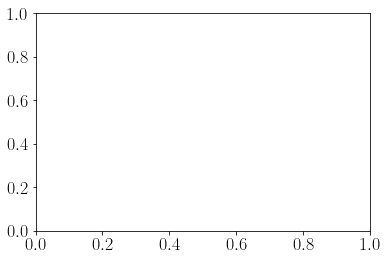

In [188]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

findfont: Font family ["'sans-serif'"] not found. Falling back to DejaVu Sans.


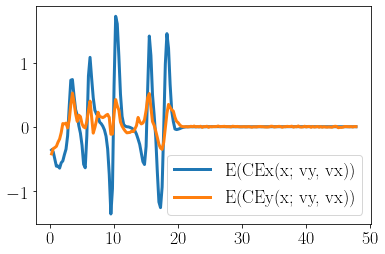

In [189]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

##  Plot fields as a function of time

In [ ]:
xxpltpoint = 20.0 #di
xxindex =  af.find_nearest(dfields['ex_xx'], xxpltpoint)
pf.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

## Test alternative get shock vel

In [ ]:
af.shockvel_from_compression_ratio(3)

In [ ]:
dM = 0.01
M = 1.1
shockvelarray = []
Minputarray = []
for k in range(0,1500):
    shockvelarray.append(af.shockvel_from_compression_ratio(M))
    Minputarray.append(M)
    M += dM
    
plt.figure()
plt.plot(Minputarray,shockvelarray)
plt.show()

In [ ]:
def shock(M):
    gamma = 5./3.
    return lambda v: 8./3.*(M-v)**2./(2./3.*(M-v)**2+2.)-M/v

from scipy.optimize import fsolve
fsolve(shock(3),2.)

In [ ]:
temparr = [1,2,3]
temparr = np.asarray(temparr)
temparr

In [ ]:
temparr += 3

In [ ]:
temparr

### Test version management

In [164]:
##TODO: version management by saving git HEAD to netcdf4 file
#os.system('git rev-parse HEAD')

import subprocess

#https://stackoverflow.com/questions/34285796/python-execute-command-and-get-output
proc = subprocess.Popen(['git', 'rev-parse', 'HEAD'], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(str(tmp)[2:-3]) #TODO: save this to netcdf4 file (edit save and load functions)

882dee9ed28e96d3165b9aef4aebcaa0e48a0738


### Find maximum speed in each direction
#### Quick check to make sure our simulation is numerically stable (max speed should be less than 25)

In [193]:
sanf.get_abs_max_velocity(dparticles)

(47.874786, 0.3749997, 0.37499824)

### Test making field pmesh

<Figure size 468x432 with 0 Axes>

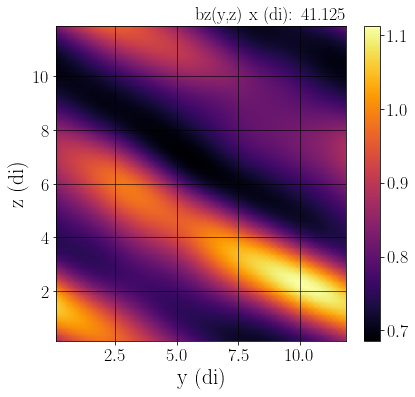

In [422]:
xxindex = 164
pf.makefieldpmesh(dfields,'bz','yz',flnm = '',takeaxisaverage=False,xxindex=xxindex)

### Test 2d fourier

In [635]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(lf)
importlib.reload(af)
importlib.reload(pf)
importlib.reload(svf)
importlib.reload(sanf)
importlib.reload(ftf)

<module 'lib.fieldtransformfunctions' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/fieldtransformfunctions.py'>

<Figure size 468x432 with 0 Axes>

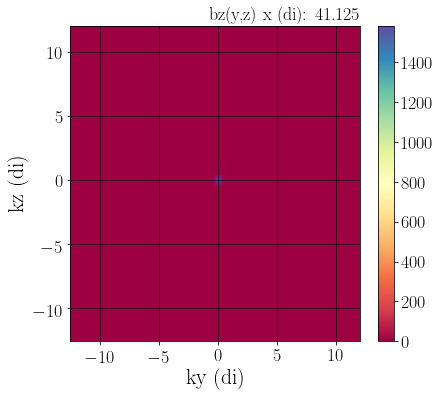

In [623]:
k0, k1, fieldpmesh, xplot, yplot = pf.plot_fft_norm(dfields,'bz','yz',plotlog = False,takeaxisaverage=False,xxindex=164)

In [621]:
1/(2*np.k0

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([         inf,  12.        ,   6.        ,   4.        ,
         3.        ,   2.4       ,   2.        ,   1.71428571,
         1.5       ,   1.33333333,   1.2       ,   1.09090909,
         1.        ,   0.92307692,   0.85714286,   0.8       ,
         0.75      ,   0.70588235,   0.66666667,   0.63157895,
         0.6       ,   0.57142857,   0.54545455,   0.52173913,
        -0.5       ,  -0.52173913,  -0.54545455,  -0.57142857,
        -0.6       ,  -0.63157895,  -0.66666667,  -0.70588235,
        -0.75      ,  -0.8       ,  -0.85714286,  -0.92307692,
        -1.        ,  -1.09090909,  -1.2       ,  -1.33333333,
        -1.5       ,  -1.71428571,  -2.        ,  -2.4       ,
        -3.        ,  -4.        ,  -6.        , -12.        ])

In [611]:
for i in range(0,len(xplot)):
    for j in range(0,len(yplot)):
        print('x: ' + str(xplot[i][j]) + ' y: ' + str(yplot[i][j]) + ' pmesh: ' + str(fieldpmesh[i][j]))

x: 0.08333333333333333 y: 0.08333333333333333 pmesh: 0.234159285116376
x: 0.16666666666666666 y: 0.08333333333333333 pmesh: 0.030261053708706537
x: 0.25 y: 0.08333333333333333 pmesh: 0.0021280188440557365
x: 0.3333333333333333 y: 0.08333333333333333 pmesh: 0.0003725189235635686
x: 0.41666666666666663 y: 0.08333333333333333 pmesh: 2.4385713606948975e-05
x: 0.5 y: 0.08333333333333333 pmesh: 1.4646671964166112e-05
x: 0.5833333333333333 y: 0.08333333333333333 pmesh: 6.78299130752773e-07
x: 0.6666666666666666 y: 0.08333333333333333 pmesh: 1.0045132614105275e-07
x: 0.75 y: 0.08333333333333333 pmesh: 2.1870676735419532e-08
x: 0.8333333333333333 y: 0.08333333333333333 pmesh: 3.8803470676631686e-09
x: 0.9166666666666666 y: 0.08333333333333333 pmesh: 3.2123023708322625e-10
x: 1.0 y: 0.08333333333333333 pmesh: 5.925070134694753e-11
x: 1.0833333333333333 y: 0.08333333333333333 pmesh: 1.5021291315886185e-12
x: 1.1666666666666665 y: 0.08333333333333333 pmesh: 6.3968408394179854e-15
x: 1.25 y: 0.0833

In [613]:
for i in range(0,len(xplot)):
    for j in range(0,len(yplot)):
        if(xplot[i][j] == yplot[i][j]):
            print('x: ' + str(xplot[i][j]) + ' y: ' + str(yplot[i][j]) + ' pmesh: ' + str(fieldpmesh[i][j]))

x: 0.08333333333333333 y: 0.08333333333333333 pmesh: 0.234159285116376
x: 0.16666666666666666 y: 0.16666666666666666 pmesh: 0.017221574971752737
x: 0.25 y: 0.25 pmesh: 0.001917886699032068
x: 0.3333333333333333 y: 0.3333333333333333 pmesh: 0.0001066666469343588
x: 0.41666666666666663 y: 0.41666666666666663 pmesh: 5.220130464939204e-06
x: 0.5 y: 0.5 pmesh: 2.215553107437772e-07
x: 0.5833333333333333 y: 0.5833333333333333 pmesh: 2.093604011603524e-08
x: 0.6666666666666666 y: 0.6666666666666666 pmesh: 2.5905839695639096e-09
x: 0.75 y: 0.75 pmesh: 2.516143739558644e-11
x: 0.8333333333333333 y: 0.8333333333333333 pmesh: 3.449751066626473e-13
x: 0.9166666666666666 y: 0.9166666666666666 pmesh: 9.217904164530678e-16
x: 1.0 y: 1.0 pmesh: 4.60896752861749e-15
x: 1.0833333333333333 y: 1.0833333333333333 pmesh: 8.459084706501367e-16
x: 1.1666666666666665 y: 1.1666666666666665 pmesh: 8.36494196244043e-16
x: 1.25 y: 1.25 pmesh: 1.2310196611562026e-14
x: 1.3333333333333333 y: 1.3333333333333333 pmesh

In [532]:
arr = []
for i in range(0,len(yplot)):
    row = []
    for j in range(0,len(yplot[i])):
        row.append(0.)
    arr.append(row)
arr = np.asarray(arr)

In [533]:
for i in range(0,len(xplot)):
    for j in range(0,len(xplot[i])):
        if(xplot[i][j] == xplot[0][3]):
            arr[i][j] = 1.

In [536]:
arr[0][0] = 5.
arr[0][1] = 3.
arr[0][2] = 1.5
arr[1][0] = 4.
arr[0][4] = 10.

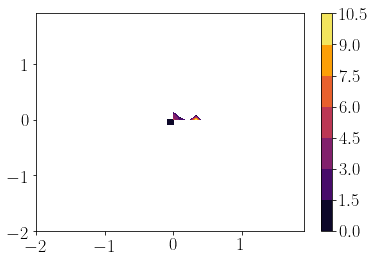

In [537]:
plt.figure()
plt.contourf(xplot,yplot,arr)
plt.colorbar()
plt.show()

In [542]:
arr[0]

array([ 5. ,  3. ,  1.5,  1. , 10. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ])

In [492]:
xplot[0]

array([  0.        ,  12.        ,   6.        ,   4.        ,
         3.        ,   2.4       ,   2.        ,   1.71428571,
         1.5       ,   1.33333333,   1.2       ,   1.09090909,
         1.        ,   0.92307692,   0.85714286,   0.8       ,
         0.75      ,   0.70588235,   0.66666667,   0.63157895,
         0.6       ,   0.57142857,   0.54545455,   0.52173913,
        -0.5       ,  -0.52173913,  -0.54545455,  -0.57142857,
        -0.6       ,  -0.63157895,  -0.66666667,  -0.70588235,
        -0.75      ,  -0.8       ,  -0.85714286,  -0.92307692,
        -1.        ,  -1.09090909,  -1.2       ,  -1.33333333,
        -1.5       ,  -1.71428571,  -2.        ,  -2.4       ,
        -3.        ,  -4.        ,  -6.        , -12.        ])

In [543]:
xplot

array([[ 0.        ,  0.08333333,  0.16666667, ..., -0.25      ,
        -0.16666667, -0.08333333],
       [ 0.        ,  0.08333333,  0.16666667, ..., -0.25      ,
        -0.16666667, -0.08333333],
       [ 0.        ,  0.08333333,  0.16666667, ..., -0.25      ,
        -0.16666667, -0.08333333],
       ...,
       [ 0.        ,  0.08333333,  0.16666667, ..., -0.25      ,
        -0.16666667, -0.08333333],
       [ 0.        ,  0.08333333,  0.16666667, ..., -0.25      ,
        -0.16666667, -0.08333333],
       [ 0.        ,  0.08333333,  0.16666667, ..., -0.25      ,
        -0.16666667, -0.08333333]])

In [544]:
yplot

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.08333333,  0.08333333,  0.08333333, ...,  0.08333333,
         0.08333333,  0.08333333],
       [ 0.16666667,  0.16666667,  0.16666667, ...,  0.16666667,
         0.16666667,  0.16666667],
       ...,
       [-0.25      , -0.25      , -0.25      , ..., -0.25      ,
        -0.25      , -0.25      ],
       [-0.16666667, -0.16666667, -0.16666667, ..., -0.16666667,
        -0.16666667, -0.16666667],
       [-0.08333333, -0.08333333, -0.08333333, ..., -0.08333333,
        -0.08333333, -0.08333333]])

In [568]:
temparr = [[1,2,3],[4,5,6],[7,8,9]]
tempx = [[1,0,-1],[1,0,-1],[1,0,-1]]
tempy = [[1,1,1],[0,0,0],[-1,-1,-1]]
tempx = np.asarray(tempx)
tempy = np.asarray(tempy)
temparr = np.asarray(temparr)

In [550]:
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))

x: 1 y: 1 arr: 1
x: 0 y: 1 arr: 2
x: -1 y: 1 arr: 3
x: 1 y: 0 arr: 4
x: 0 y: 0 arr: 5
x: -1 y: 0 arr: 6
x: 1 y: -1 arr: 7
x: 0 y: -1 arr: 8
x: -1 y: -1 arr: 9


In [551]:
np.argsort(tempx)

array([[2, 1, 0],
       [2, 1, 0],
       [2, 1, 0]])

In [552]:
np.sort(tempx)

array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])

In [553]:
np.argsort(tempx)

array([[2, 1, 0],
       [2, 1, 0],
       [2, 1, 0]])

In [557]:
temparr[np.argsort(tempx)[0]][np.argsort(tempy)[:]]

array([[[7, 8, 9],
        [4, 5, 6],
        [1, 2, 3]],

       [[7, 8, 9],
        [4, 5, 6],
        [1, 2, 3]],

       [[7, 8, 9],
        [4, 5, 6],
        [1, 2, 3]]])

In [564]:
temprowx = tempx[0]
xsort = np.argsort(temprowx)
xsort

array([2, 1, 0])

In [571]:
tempcoly = tempy[:,0]
ysort = np.argsort(tempcoly)

In [572]:
for i in range(0,len(temparr)):
    temparr[i] = temparr[i][xsort]
temparr

array([[3, 2, 1],
       [6, 5, 4],
       [9, 8, 7]])

In [573]:
temparr = temparr[ysort]

In [574]:
temparr

array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

In [578]:
tempx = np.sort(tempx)
tempy = np.sort(tempy,axis=0)

In [579]:
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))

x: -1 y: -1 arr: 9
x: 0 y: -1 arr: 8
x: 1 y: -1 arr: 7
x: -1 y: 0 arr: 6
x: 0 y: 0 arr: 5
x: 1 y: 0 arr: 4
x: -1 y: 1 arr: 3
x: 0 y: 1 arr: 2
x: 1 y: 1 arr: 1


In [577]:
np.sort(tempy,axis=0)

array([[-1, -1, -1],
       [ 0,  0,  0],
       [ 1,  1,  1]])

In [581]:
#Test sorting 'double parallel' array
#need to sort tempx by row, sort tempy by column, and maintain same order with temparr

#build arrays
temparr = [[1,2,3],[4,5,6],[7,8,9]]
tempx = [[1,0,-1],[1,0,-1],[1,0,-1]]
tempy = [[1,1,1],[0,0,0],[-1,-1,-1]]
tempx = np.asarray(tempx)
tempy = np.asarray(tempy)
temparr = np.asarray(temparr)

#print before
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))
        
#sort        
temprowx = tempx[0]
xsort = np.argsort(temprowx)
tempcoly = tempy[:,0]
ysort = np.argsort(tempcoly)
for i in range(0,len(temparr)): #sort by col
    temparr[i] = temparr[i][xsort]
temparr = temparr[ysort] #sort by row
tempx = np.sort(tempx) #sort x data
tempy = np.sort(tempy,axis=0) #sort y data

#print after
print('-----after------')
for i in range(0,len(tempx)):
    for j in range(0,len(tempy)):
        print('x: ' + str(tempx[i][j]) + ' y: ' + str(tempy[i][j]) + ' arr: ' + str(temparr[i][j]))

x: 1 y: 1 arr: 1
x: 0 y: 1 arr: 2
x: -1 y: 1 arr: 3
x: 1 y: 0 arr: 4
x: 0 y: 0 arr: 5
x: -1 y: 0 arr: 6
x: 1 y: -1 arr: 7
x: 0 y: -1 arr: 8
x: -1 y: -1 arr: 9
-----after------
x: -1 y: -1 arr: 9
x: 0 y: -1 arr: 8
x: 1 y: -1 arr: 7
x: -1 y: 0 arr: 6
x: 0 y: 0 arr: 5
x: 1 y: 0 arr: 4
x: -1 y: 1 arr: 3
x: 0 y: 1 arr: 2
x: 1 y: 1 arr: 1


In [598]:
temparr = np.asarray([1,2,0.,3.])
np.where(temparr == 0)[0][0]

2

In [595]:
temparr

[1, 2, 0.0, 3.0]

### Estimate Ripple size

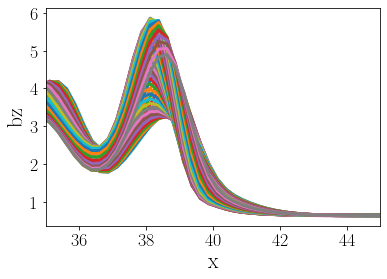

In [636]:
pf.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0,xlow=35.,xhigh=45.)

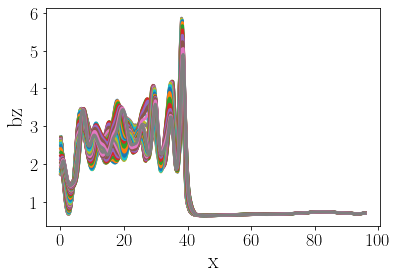

In [637]:
pf.plot_stack_field_along_x(dfields,'bz','_yy',yyindex=0,zzindex=0)